In [5]:
import pandas as pd
import numpy as np
import re
import pickle
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
#from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle


In [6]:
dataset = pd.read_csv("data_final.csv")
dataset.dropna(inplace=True)
dataset.head()

,tweet,label
1,RT @colonelkickhead: Another bloody instant re...,none
3,@azzamalirhabi @JihadiA8 This video of the Pes...,none
5,Oh really? No more instant restaurants? THAT'S...,none
7,RT @Benfrancisallen: It hasn't been a good few...,none
9,RT @NoToFeminism: I donâ€™t need femisnsn beca...,none


In [7]:
dataset.shape

(16090, 2)

In [8]:
def preprocess_text(sen):
    sentence = remove_tags(sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [9]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)


In [10]:
X = []
sentences = list(dataset['tweet'])
for sen in sentences:
    X.append(preprocess_text(sen))


In [11]:
dataset["label"].unique()

array(['none', 'racism', 'sexism'], dtype=object)

In [12]:
dataset.label.value_counts()


none      11036
sexism     3117
racism     1937
Name: label, dtype: int64

In [13]:
le=LabelEncoder()

In [14]:
le.fit(dataset["label"])

LabelEncoder()

In [15]:
print("\nDataset Labels:(y values)\n",list(le.classes_))


Dataset Labels:(y values)
 ['none', 'racism', 'sexism']


In [16]:
y=le.transform(dataset["label"])
y

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [18]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

In [19]:

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100


In [21]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
X_train.shape

(12872, 100)

In [23]:
y_train.shape

(12872,)

In [24]:
from lightgbm import LGBMClassifier

classifier_lgbm = LGBMClassifier()
classifier_lgbm.fit(X_train, y_train)

LGBMClassifier()

In [25]:
y_pred_lgbm=classifier_lgbm.predict(X_test)
y_pred_lgbm

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
print("accuracy_score_lgbm: \n",accuracy_score(y_test,y_pred_lgbm)*100) 

accuracy_score_lgbm: 
 73.86575512740833


In [27]:
print("confusion_matrix: \n",confusion_matrix(y_test,y_pred_lgbm))

confusion_matrix: 
 [[2098   67   35]
 [ 300  103    1]
 [ 436    2  176]]


In [28]:
print("classification_report: \n",classification_report(y_test,y_pred_lgbm))

classification_report: 
               precision    recall  f1-score   support

           0       0.74      0.95      0.83      2200
           1       0.60      0.25      0.36       404
           2       0.83      0.29      0.43       614

    accuracy                           0.74      3218
   macro avg       0.72      0.50      0.54      3218
weighted avg       0.74      0.74      0.70      3218



In [29]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_lgbm)

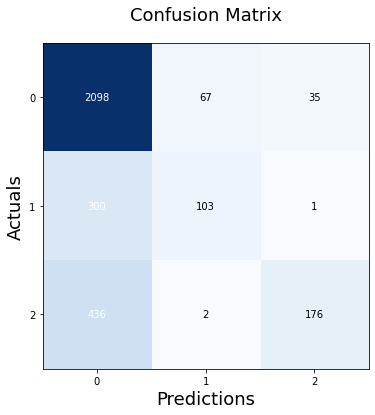

In [30]:
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_confusion_matrix
 
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

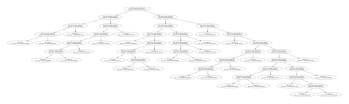

In [31]:
import lightgbm
from sklearn.tree import plot_tree
lightgbm.plot_tree(classifier_lgbm)

>10 0.857 (0.033)
>50 0.916 (0.032)
>100 0.925 (0.031)
>500 0.938 (0.026)
>1000 0.938 (0.028)
>5000 0.937 (0.028)


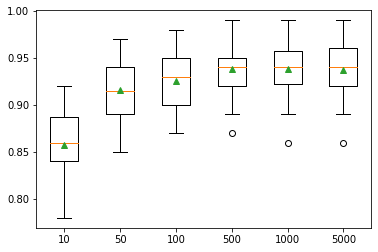

In [32]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	return X, y
 
# get a list of models to evaluate
def get_models():
	models = dict()
	trees = [10, 50, 100, 500, 1000, 5000]
	for n in trees:
		models[str(n)] = LGBMClassifier(n_estimators=n)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [49]:
#import lightgbm
#from sklearn.tree import plot_tree
#viz = lightgbm.create_tree_digraph(classifier_lgbm.booster_)
#viz

In [38]:

from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier(n_estimators=20)
clf_forest.fit(X_train,y_train)
y_pred_forest = clf_forest.predict(X_test)
print( "Accuracy is ", accuracy_score(y_test,y_pred_forest)*100,"% for Random Forest Classifier")

Accuracy is  71.00683654443753 % for Random Forest Classifier


In [39]:
#Importing basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Importing sklearn modules
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [53]:
# Application of all Machine Learning methods
models = []

models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('Random forest',RandomForestClassifier()))
models.append(('LightGBM',LGBMClassifier()))

LDA: 0.684432 (0.005655)
KNN: 0.654834 (0.009363)
CART: 0.601538 (0.008469)
NB: 0.127253 (0.007812)
Random forest: 0.719314 (0.008222)
LightGBM: 0.739358 (0.009854)


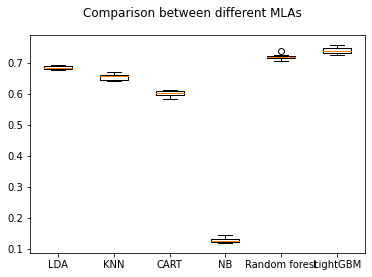

In [54]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparison between different MLAs')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()